In [1]:
import os
import bioimage

from interactive_m2unet import M2UnetInteractiveModel
import numpy as np
import imageio
import albumentations as A
from skimage.filters import threshold_otsu
from skimage.measure import label
# Uncomment to specify the gpu number
# os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import torch
torch.backends.cudnn.benchmark = True
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader,Dataset
from torchvision.utils import make_grid
import math



/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.7/site-packages/bioimageio/spec/shared/_resolve_source.py:433: CacheWarning: found cached /tmp/jupyter/bioimageio_cache/https/raw.githubusercontent.com/bioimage-io/bioimage.io/main/site.config.json. Skipping download of https://raw.githubusercontent.com/bioimage-io/bioimage.io/main/site.config.json.
  warnings.warn(f"found cached {local_path}. Skipping download of {uri}.", category=CacheWarning)
/opt/conda/lib/python3.7/site-packages/bioimageio/spec/shared/_resolve_source.py:433: CacheWarning: found cached /tmp/jupyter/bioimageio_cache/https/bioimage-io.github.io/collection-bioimage-io/collection.json. Skipping download of https://bioimage-io.github.io/collection-bioimage-io/collection.json.
  warnings.warn(f"found cached {

In [2]:
'''
Original m2unet
'''

def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]
        
        # self.quant = torch.quantization.QuantStub()
        # self.dequant = torch.quantization.DeQuantStub()


        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            # depthwise separable convolution block
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            # Bottleneck with expansion layer
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)
        
class Encoder(nn.Module):
    """
    14 layers of MobileNetv2 as encoder part
    """
    def __init__(self):
        super(Encoder, self).__init__()
        block = InvertedResidual
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
        ]
        # Encoder Part
        input_channel = 32 # number of input channels to first inverted (residual) block
        self.layers = [conv_bn(3, 32, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = c
            for i in range(n):
                if i == 0:
                    self.layers.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.layers.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # make it nn.Sequential
        self.layers = nn.Sequential(*self.layers)
                
class DecoderBlock(nn.Module):
    """
    Decoder block: upsample and concatenate with features maps from the encoder part
    """
    def __init__(self,up_in_c,x_in_c,upsamplemode='bilinear',expand_ratio=0.15):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2,mode=upsamplemode,align_corners=False) # H, W -> 2H, 2W
        self.ir1 = InvertedResidual(up_in_c+x_in_c,(x_in_c + up_in_c) // 2,stride=1,expand_ratio=expand_ratio)

    def forward(self,up_in,x_in):
        up_out = self.upsample(up_in)
        cat_x = torch.cat([up_out, x_in] , dim=1)
        x = self.ir1(cat_x)
        return x
    
class LastDecoderBlock(nn.Module):
    def __init__(self,x_in_c,upsamplemode='bilinear',expand_ratio=0.15, output_channels=1, activation='linear'):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2,mode=upsamplemode,align_corners=False) # H, W -> 2H, 2W
        self.ir1 = InvertedResidual(x_in_c,16,stride=1,expand_ratio=expand_ratio)
        layers =  [
            nn.Conv2d(16, output_channels, 1, 1, 0, bias=True),
        ]
        if activation == 'sigmoid':
            layers.append(nn.Sigmoid())
        elif activation == 'softmax':
            layers.append(nn.Softmax(dim=1))
        elif activation == 'linear' or activation is None:
            pass
        else:
            raise NotImplementedError('Activation {} not implemented'.format(activation))
        self.conv = nn.Sequential(
           *layers
        )

    def forward(self,up_in,x_in):
        up_out = self.upsample(up_in)
        cat_x = torch.cat([up_out, x_in] , dim=1)
        x = self.ir1(cat_x)
        x = self.conv(x)
        return x
    
class M2UNet(nn.Module):
        def __init__(self,encoder,upsamplemode='bilinear',output_channels=1, activation="linear", expand_ratio=0.15):
            super(M2UNet,self).__init__()
            encoder = list(encoder.children())[0]
            # Encoder
            self.conv1 = encoder[0:2]
            self.conv2 = encoder[2:4]
            self.conv3 = encoder[4:7]
            self.conv4 = encoder[7:14]
            # Decoder
            self.decode4 = DecoderBlock(96,32,upsamplemode,expand_ratio)
            self.decode3 = DecoderBlock(64,24,upsamplemode,expand_ratio)
            self.decode2 = DecoderBlock(44,16,upsamplemode,expand_ratio)
            self.decode1 = LastDecoderBlock(33,upsamplemode,expand_ratio, output_channels=output_channels, activation=activation)
            # initilaize weights 
            self._init_params()

        def _init_params(self):
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.zero_()
                elif isinstance(m, nn.BatchNorm2d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
                elif isinstance(m, nn.Linear):
                    n = m.weight.size(1)
                    m.weight.data.normal_(0, 0.01)
                    m.bias.data.zero_()
            
        
        
        def forward(self,x):
            conv1 = self.conv1(x)
            conv2 = self.conv2(conv1)
            conv3 = self.conv3(conv2)
            conv4 = self.conv4(conv3)
            decode4 = self.decode4(conv4,conv3)
            decode3 = self.decode3(decode4,conv2)
            decode2 = self.decode2(decode3,conv1)
            decode1 = self.decode1(decode2,x)
            return decode1
        
class M2UNet_q(nn.Module):
        def __init__(self,encoder,upsamplemode='bilinear',output_channels=1, activation="linear", expand_ratio=0.15):
            super(M2UNet_q,self).__init__()
            encoder = list(encoder.children())[0]
            # Encoder
            self.quant = torch.quantization.QuantStub()

            self.conv1 = encoder[0:2]
            self.conv2 = encoder[2:4]
            self.conv3 = encoder[4:7]
            self.conv4 = encoder[7:14]
            # Decoder
            self.decode4 = DecoderBlock(96,32,upsamplemode,expand_ratio)
            self.decode3 = DecoderBlock(64,24,upsamplemode,expand_ratio)
            self.decode2 = DecoderBlock(44,16,upsamplemode,expand_ratio)
            self.decode1 = LastDecoderBlock(33,upsamplemode,expand_ratio, output_channels=output_channels, activation=activation)
            
            self.dequant = torch.quantization.DeQuantStub()

            # initilaize weights 
            self._init_params()

        def _init_params(self):
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.zero_()
                elif isinstance(m, nn.BatchNorm2d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
                elif isinstance(m, nn.Linear):
                    n = m.weight.size(1)
                    m.weight.data.normal_(0, 0.01)
                    m.bias.data.zero_()
            
        
        
        def forward(self,x):
            x = self.quant(x)

            conv1 = self.conv1(x)
            conv2 = self.conv2(conv1)
            conv3 = self.conv3(conv2)
            conv4 = self.conv4(conv3)
            decode4 = self.decode4(conv4,conv3)
            decode3 = self.decode3(decode4,conv2)
            decode2 = self.decode2(decode3,conv1)
            decode1 = self.decode1(decode2,x)
            
            res = self.dequant(decode1)

            
            return res
        
def m2unet(output_channels=1,expand_ratio=0.15, activation="linear", **kwargs):
    encoder = Encoder()
    model = M2UNet(encoder,upsamplemode='bilinear',expand_ratio=expand_ratio, output_channels=output_channels, activation=activation)
    return model

def m2unet_q(output_channels=1,expand_ratio=0.15, activation="linear", **kwargs):
    encoder = Encoder()
    model = M2UNet_q(encoder,upsamplemode='bilinear',expand_ratio=expand_ratio, output_channels=output_channels, activation=activation)
    return model


## Defines Unet

import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader,Dataset
# from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

class Convblock(nn.Module):
    
      def __init__(self,input_channel,output_channel,kernal=3,stride=1,padding=1):
            
        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(input_channel,output_channel,kernal,stride,padding),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel,output_channel,kernal),
            nn.ReLU(inplace=True),
        )
    

      def forward(self,x):
        x = self.convblock(x)
        return x
    
class UNet(nn.Module):
    
    def __init__(self,input_channel,retain=True):

        super().__init__()

        self.conv1 = Convblock(input_channel,32)
        self.conv2 = Convblock(32,64)
        self.conv3 = Convblock(64,128)
        self.conv4 = Convblock(128,256)
        self.neck = nn.Conv2d(256,512,3,1)
        self.upconv4 = nn.ConvTranspose2d(512,256,3,2,0,1)
        self.dconv4 = Convblock(512,256)
        self.upconv3 = nn.ConvTranspose2d(256,128,3,2,0,1)
        self.dconv3 = Convblock(256,128)
        self.upconv2 = nn.ConvTranspose2d(128,64,3,2,0,1)
        self.dconv2 = Convblock(128,64)
        self.upconv1 = nn.ConvTranspose2d(64,32,3,2,0,1)
        self.dconv1 = Convblock(64,32)
        self.out = nn.Conv2d(32,1,1,1)
        self.retain = retain
        
    def forward(self,x):
        
        # Encoder Network
        
        # Conv down 1
        conv1 = self.conv1(x)
        pool1 = F.max_pool2d(conv1,kernel_size=2,stride=2)
        # Conv down 2
        conv2 = self.conv2(pool1)
        pool2 = F.max_pool2d(conv2,kernel_size=2,stride=2)
        # Conv down 3
        conv3 = self.conv3(pool2)
        pool3 = F.max_pool2d(conv3,kernel_size=2,stride=2)
        # Conv down 4
        conv4 = self.conv4(pool3)
        pool4 = F.max_pool2d(conv4,kernel_size=2,stride=2)

        # BottelNeck
        neck = self.neck(pool4)
        
        # Decoder Network
        
        # Upconv 1
        upconv4 = self.upconv4(neck)
        croped = self.crop(conv4,upconv4)
        # Making the skip connection 1
        dconv4 = self.dconv4(torch.cat([upconv4,croped],1))
        # Upconv 2
        upconv3 = self.upconv3(dconv4)
        croped = self.crop(conv3,upconv3)
        # Making the skip connection 2
        dconv3 = self.dconv3(torch.cat([upconv3,croped],1))
        # Upconv 3
        upconv2 = self.upconv2(dconv3)
        croped = self.crop(conv2,upconv2)
        # Making the skip connection 3
        dconv2 = self.dconv2(torch.cat([upconv2,croped],1))
        # Upconv 4
        upconv1 = self.upconv1(dconv2)
        croped = self.crop(conv1,upconv1)
        # Making the skip connection 4
        dconv1 = self.dconv1(torch.cat([upconv1,croped],1))
        # Output Layer
        out = self.out(dconv1)
        
        if self.retain == True:
            out = F.interpolate(out,list(x.shape)[2:])

        return out
    
    def crop(self,input_tensor,target_tensor):
        # For making the size of the encoder conv layer and the decoder Conv layer same
        _,_,H,W = target_tensor.shape
        return transform.CenterCrop([H,W])(input_tensor)
    
class UNet_q(nn.Module):
    
    def __init__(self,input_channel,retain=True):

        super().__init__()
        
        self.quant = torch.quantization.QuantStub()

        self.conv1 = Convblock(input_channel,32)
        self.conv2 = Convblock(32,64)
        self.conv3 = Convblock(64,128)
        self.conv4 = Convblock(128,256)
        self.neck = nn.Conv2d(256,512,3,1)
        self.upconv4 = nn.ConvTranspose2d(512,256,3,2,0,1)
        self.dconv4 = Convblock(512,256)
        self.upconv3 = nn.ConvTranspose2d(256,128,3,2,0,1)
        self.dconv3 = Convblock(256,128)
        self.upconv2 = nn.ConvTranspose2d(128,64,3,2,0,1)
        self.dconv2 = Convblock(128,64)
        self.upconv1 = nn.ConvTranspose2d(64,32,3,2,0,1)
        self.dconv1 = Convblock(64,32)
        self.out = nn.Conv2d(32,1,1,1)
        self.retain = retain
        
        self.dequant = torch.quantization.DeQuantStub()

        
    def forward(self,x):
        
        # Encoder Network
        
        # Conv down 1
        x = self.quant(x)
        conv1 = self.conv1(x)
        pool1 = F.max_pool2d(conv1,kernel_size=2,stride=2)
        # Conv down 2
        conv2 = self.conv2(pool1)
        pool2 = F.max_pool2d(conv2,kernel_size=2,stride=2)
        # Conv down 3
        conv3 = self.conv3(pool2)
        pool3 = F.max_pool2d(conv3,kernel_size=2,stride=2)
        # Conv down 4
        conv4 = self.conv4(pool3)
        pool4 = F.max_pool2d(conv4,kernel_size=2,stride=2)

        # BottelNeck
        neck = self.neck(pool4)
        
        # Decoder Network
        
        # Upconv 1
        upconv4 = self.upconv4(neck)
        croped = self.crop(conv4,upconv4)
        # Making the skip connection 1
        dconv4 = self.dconv4(torch.cat([upconv4,croped],1))
        # Upconv 2
        upconv3 = self.upconv3(dconv4)
        croped = self.crop(conv3,upconv3)
        # Making the skip connection 2
        dconv3 = self.dconv3(torch.cat([upconv3,croped],1))
        # Upconv 3
        upconv2 = self.upconv2(dconv3)
        croped = self.crop(conv2,upconv2)
        # Making the skip connection 3
        dconv2 = self.dconv2(torch.cat([upconv2,croped],1))
        # Upconv 4
        upconv1 = self.upconv1(dconv2)
        croped = self.crop(conv1,upconv1)
        # Making the skip connection 4
        dconv1 = self.dconv1(torch.cat([upconv1,croped],1))
        # Output Layer
        out = self.out(dconv1)
        
        out = self.dequant(dconv1)
        
        if self.retain == True:
            out = F.interpolate(out,list(x.shape)[2:])

        return out
    
    def crop(self,input_tensor,target_tensor):
        # For making the size of the encoder conv layer and the decoder Conv layer same
        _,_,H,W = target_tensor.shape
        return transform.CenterCrop([H,W])(input_tensor)
 

In [3]:
'''
Modified m2unet for quantization
'''

def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        self.add = nn.quantized.FloatFunctional()

        
        assert stride in [1, 2]
        
        # self.quant = torch.quantization.QuantStub()
        # self.dequant = torch.quantization.DeQuantStub()


        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            # depthwise separable convolution block
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            # Bottleneck with expansion layer
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            # return x + self.conv(x)
            return self.add.add(x, self.conv(x))
        else:
            return self.conv(x)
        
class Encoder(nn.Module):
    """
    14 layers of MobileNetv2 as encoder part
    """
    def __init__(self):
        super(Encoder, self).__init__()
        block = InvertedResidual
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
        ]
        # Encoder Part
        input_channel = 32 # number of input channels to first inverted (residual) block
        self.layers = [conv_bn(3, 32, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = c
            for i in range(n):
                if i == 0:
                    self.layers.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.layers.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # make it nn.Sequential
        self.layers = nn.Sequential(*self.layers)
                
class DecoderBlock(nn.Module):
    """
    Decoder block: upsample and concatenate with features maps from the encoder part
    """
    def __init__(self,up_in_c,x_in_c,upsamplemode='bilinear',expand_ratio=0.15):
        super().__init__()
        self.cat = nn.quantized.FloatFunctional()

        self.upsample = nn.Upsample(scale_factor=2,mode=upsamplemode,align_corners=False) # H, W -> 2H, 2W
        self.ir1 = InvertedResidual(up_in_c+x_in_c,(x_in_c + up_in_c) // 2,stride=1,expand_ratio=expand_ratio)

    def forward(self,up_in,x_in):
        up_out = self.upsample(up_in)
        # cat_x = torch.cat([up_out, x_in] , dim=1)
        cat_x = self.cat.cat([up_out, x_in] , dim=1)
        x = self.ir1(cat_x)
        return x
    
class LastDecoderBlock(nn.Module):
    def __init__(self,x_in_c,upsamplemode='bilinear',expand_ratio=0.15, output_channels=1, activation='linear'):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2,mode=upsamplemode,align_corners=False) # H, W -> 2H, 2W
        self.ir1 = InvertedResidual(x_in_c,16,stride=1,expand_ratio=expand_ratio)
        layers =  [
            nn.Conv2d(16, output_channels, 1, 1, 0, bias=True),
        ]
        self.cat = nn.quantized.FloatFunctional()

        if activation == 'sigmoid':
            layers.append(nn.Sigmoid())
        elif activation == 'softmax':
            layers.append(nn.Softmax(dim=1))
        elif activation == 'linear' or activation is None:
            pass
        else:
            raise NotImplementedError('Activation {} not implemented'.format(activation))
        self.conv = nn.Sequential(
           *layers
        )

    def forward(self,up_in,x_in):
        up_out = self.upsample(up_in)
        # cat_x = torch.cat([up_out, x_in] , dim=1)
        cat_x = self.cat.cat([up_out, x_in] , dim=1)
        x = self.ir1(cat_x)
        x = self.conv(x)
        return x
    
class M2UNet(nn.Module):
        def __init__(self,encoder,upsamplemode='bilinear',output_channels=1, activation="linear", expand_ratio=0.15):
            super(M2UNet,self).__init__()
            encoder = list(encoder.children())[0]
            # Encoder
            self.conv1 = encoder[0:2]
            self.conv2 = encoder[2:4]
            self.conv3 = encoder[4:7]
            self.conv4 = encoder[7:14]
            # Decoder
            self.decode4 = DecoderBlock(96,32,upsamplemode,expand_ratio)
            self.decode3 = DecoderBlock(64,24,upsamplemode,expand_ratio)
            self.decode2 = DecoderBlock(44,16,upsamplemode,expand_ratio)
            self.decode1 = LastDecoderBlock(33,upsamplemode,expand_ratio, output_channels=output_channels, activation=activation)
            # initilaize weights 
            self._init_params()

        def _init_params(self):
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.zero_()
                elif isinstance(m, nn.BatchNorm2d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
                elif isinstance(m, nn.Linear):
                    n = m.weight.size(1)
                    m.weight.data.normal_(0, 0.01)
                    m.bias.data.zero_()
            
        
        
        def forward(self,x):
            conv1 = self.conv1(x)
            conv2 = self.conv2(conv1)
            conv3 = self.conv3(conv2)
            conv4 = self.conv4(conv3)
            decode4 = self.decode4(conv4,conv3)
            decode3 = self.decode3(decode4,conv2)
            decode2 = self.decode2(decode3,conv1)
            decode1 = self.decode1(decode2,x)
            return decode1
        
class M2UNet_q2(nn.Module):
        def __init__(self,encoder,upsamplemode='bilinear',output_channels=1, activation="linear", expand_ratio=0.15):
            super(M2UNet_q2,self).__init__()
            encoder = list(encoder.children())[0]
            # Encoder
            self.quant = torch.quantization.QuantStub()

            self.conv1 = encoder[0:2]
            self.conv2 = encoder[2:4]
            self.conv3 = encoder[4:7]
            self.conv4 = encoder[7:14]
            # Decoder
            self.decode4 = DecoderBlock(96,32,upsamplemode,expand_ratio)
            self.decode3 = DecoderBlock(64,24,upsamplemode,expand_ratio)
            self.decode2 = DecoderBlock(44,16,upsamplemode,expand_ratio)
            self.decode1 = LastDecoderBlock(33,upsamplemode,expand_ratio, output_channels=output_channels, activation=activation)
            
            self.dequant = torch.quantization.DeQuantStub()

            # initilaize weights 
            self._init_params()

        def _init_params(self):
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.zero_()
                elif isinstance(m, nn.BatchNorm2d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
                elif isinstance(m, nn.Linear):
                    n = m.weight.size(1)
                    m.weight.data.normal_(0, 0.01)
                    m.bias.data.zero_()
            
        
        
        def forward(self,x):
            x = self.quant(x)

            conv1 = self.conv1(x)
            conv2 = self.conv2(conv1)
            conv3 = self.conv3(conv2)
            conv4 = self.conv4(conv3)
            decode4 = self.decode4(conv4,conv3)
            decode3 = self.decode3(decode4,conv2)
            decode2 = self.decode2(decode3,conv1)
            decode1 = self.decode1(decode2,x)
            
            res = self.dequant(decode1)

            
            return res
        
def m2unet(output_channels=1,expand_ratio=0.15, activation="linear", **kwargs):
    encoder = Encoder()
    model = M2UNet(encoder,upsamplemode='bilinear',expand_ratio=expand_ratio, output_channels=output_channels, activation=activation)
    return model

def m2unet_q2(output_channels=1,expand_ratio=0.15, activation="linear", **kwargs):
    encoder = Encoder()
    model = M2UNet_q2(encoder,upsamplemode='bilinear',expand_ratio=expand_ratio, output_channels=output_channels, activation=activation)
    return model



In [4]:
from torchvision.transforms import ToTensor, Lambda

def load_samples(train_dir, size, sub_samples):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    sz = size
    transform = A.Compose(
    [
        A.RandomCrop(sz, sz),
        #A.Rotate(limit=[-5, 5], p=1),
        # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.Flip(p=0.5),
        #A.CenterCrop(sz, sz),
    ])
    
    # data_transform = transforms.Compose([
    #     transforms.RandomResizedCrop(sz),
    #     transforms.ToTensor(),
    # ])
    
    print('started data loading')
    npy_files = [os.path.join(train_dir, s) for s in os.listdir(train_dir) if s.endswith('.npy')]
    samples = []
    for file in npy_files:
        # print(file)
        try:
            items = np.load(file, allow_pickle=True).item()
        except:
            print("Bad Item")
            continue
        
        
        mask = (items['masks'][:, :, None]  > 0) * 1.0
        outline = (items['outlines'][:, :, None]  > 0) * 1.0
        mask = mask * (1.0 - outline)
        # sample = (items['img'], mask)
        # sample_transform = transform(image = items['img'])
        # label_transform = transform(image  = mask)
        
        for i in range(sub_samples):
            transformed = transform(image=items['img'], mask= mask)
            transformed_image = transformed['image']
            transformed_mask = transformed['mask']

            transformed_image = np.swapaxes(transformed_image, 0, 2)
            transformed_mask = np.swapaxes(transformed_mask, 0, 2)
            
            transformed_image = torch.tensor(transformed_image)
            transformed_mask = torch.tensor(transformed_mask)

            
            image = transformed_image.float().to(device)
            image = image / 256 # pushing data between 0 and 1
            label = transformed_mask.float().to(device)

            sample = (image, label)

            samples.append(sample)
    
        
        # sample_transform = data_transform(items['img'])
        # label_transform = data_transform(mask)
        
    print('completed')
    return samples



In [5]:
# Load data into Dataloader

data_dir = './cell_data_3' # data should contain a train and a test folder

size = 512
sub_samples = 8

train_samples = load_samples(data_dir + '/train', size, sub_samples)
test_samples = load_samples(data_dir + '/test',size, sub_samples)

# Load data into Dataloader

# for (images, labels) in enum
bs = 4
train_dataloader = DataLoader(train_samples, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_samples, batch_size=1, shuffle=True)


started data loading
completed
started data loading
completed


In [6]:
'''
Train m2unet model
'''

# initializing the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = m2unet_q2().to(device)

lr = 0.001
epochs = 50
train_acc = []
val_acc = []
train_loss = []
val_loss = []


lossfunc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# import torch
# model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=False)
# model = model.to(device)

for i in range(epochs):
    
    trainloss = 0
    valloss = 0
    
    for img,label in tqdm(train_dataloader):
        '''
            Traning the Model.
        '''
        optimizer.zero_grad()
        # img = img.float().to(device)
        # img = img / 256 # pushing data between 0 and 1
        # label = label.float().to(device)
        
     
  

        output = model(img)
    


        loss = lossfunc(output,label)
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()
    
    # if(i%5==0):
    #     show(img,output,label)

    train_loss.append(trainloss/len(train_dataloader))    
    
  
    for img,label in tqdm(test_dataloader):
        '''
            Validation of Model.
        '''
        img = img.float().to(device)
        # img = img / 256 # pushing data between 0 and 1

        label = label.float().to(device)
       
        
        output = model(img)
        loss = lossfunc(output,label)
        valloss+=loss.item()
        
    val_loss.append(valloss/len(test_dataloader))  
    

    print("epoch : {} ,train loss : {} ,valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))



cuda:0


100%|██████████| 160/160 [00:01<00:00, 88.67it/s]


epoch : 0 ,train loss : 1.433211333770305 ,valid loss : 0.23841283842921257 


100%|██████████| 160/160 [00:01<00:00, 91.12it/s]


epoch : 1 ,train loss : 0.20078482953831553 ,valid loss : 0.16274669342674314 


100%|██████████| 160/160 [00:01<00:00, 91.47it/s]


epoch : 2 ,train loss : 0.1464600058272481 ,valid loss : 0.1279542388394475 


100%|██████████| 160/160 [00:01<00:00, 89.17it/s]


epoch : 3 ,train loss : 0.10961232259869576 ,valid loss : 0.09069424676708877 


100%|██████████| 160/160 [00:01<00:00, 88.32it/s]


epoch : 4 ,train loss : 0.07906163323204965 ,valid loss : 0.06927993870340288 


100%|██████████| 160/160 [00:01<00:00, 91.21it/s]


epoch : 5 ,train loss : 0.06190955359488726 ,valid loss : 0.058060765243135394 


100%|██████████| 160/160 [00:01<00:00, 91.10it/s]


epoch : 6 ,train loss : 0.053789278701879085 ,valid loss : 0.05222539254464209 


100%|██████████| 160/160 [00:01<00:00, 90.52it/s]


epoch : 7 ,train loss : 0.04831200847402215 ,valid loss : 0.04817389308009297 


100%|██████████| 160/160 [00:01<00:00, 88.77it/s]


epoch : 8 ,train loss : 0.04477511225268245 ,valid loss : 0.04485861272551119 


100%|██████████| 160/160 [00:01<00:00, 90.17it/s]


epoch : 9 ,train loss : 0.04202745798975229 ,valid loss : 0.04260060498490929 


100%|██████████| 160/160 [00:01<00:00, 90.78it/s]


epoch : 10 ,train loss : 0.03963528925087303 ,valid loss : 0.04063744756858796 


100%|██████████| 160/160 [00:01<00:00, 89.81it/s]


epoch : 11 ,train loss : 0.037607039918657395 ,valid loss : 0.03872178563615307 


100%|██████████| 160/160 [00:01<00:00, 91.40it/s]


epoch : 12 ,train loss : 0.03588434203993529 ,valid loss : 0.037204547773580995 


100%|██████████| 160/160 [00:01<00:00, 91.75it/s]


epoch : 13 ,train loss : 0.034867855662014335 ,valid loss : 0.036300267896149305 


100%|██████████| 160/160 [00:01<00:00, 91.88it/s]


epoch : 14 ,train loss : 0.03347757344599813 ,valid loss : 0.03492621969198808 


100%|██████████| 160/160 [00:01<00:00, 90.87it/s]


epoch : 15 ,train loss : 0.03252669252688065 ,valid loss : 0.03392761560389772 


100%|██████████| 160/160 [00:01<00:00, 91.35it/s]


epoch : 16 ,train loss : 0.03166774876881391 ,valid loss : 0.03368938941275701 


100%|██████████| 160/160 [00:01<00:00, 91.00it/s]


epoch : 17 ,train loss : 0.030567674816120417 ,valid loss : 0.03277806402184069 


100%|██████████| 160/160 [00:01<00:00, 90.31it/s]


epoch : 18 ,train loss : 0.029574629000853746 ,valid loss : 0.03197080766549334 


100%|██████████| 160/160 [00:01<00:00, 90.97it/s]


epoch : 19 ,train loss : 0.029138630779925734 ,valid loss : 0.031241537700407208 


100%|██████████| 160/160 [00:01<00:00, 89.97it/s]


epoch : 20 ,train loss : 0.028487585159018634 ,valid loss : 0.030595448892563583 


100%|██████████| 160/160 [00:01<00:00, 89.42it/s]


epoch : 21 ,train loss : 0.027991767192725094 ,valid loss : 0.030097595369443297 


100%|██████████| 160/160 [00:01<00:00, 91.45it/s]


epoch : 22 ,train loss : 0.02745075327111408 ,valid loss : 0.02976004589581862 


100%|██████████| 160/160 [00:01<00:00, 89.68it/s]


epoch : 23 ,train loss : 0.02683472876669839 ,valid loss : 0.02889543299097568 


100%|██████████| 160/160 [00:01<00:00, 89.31it/s]


epoch : 24 ,train loss : 0.02676233776146546 ,valid loss : 0.028896530577912926 


100%|██████████| 160/160 [00:01<00:00, 91.67it/s]


epoch : 25 ,train loss : 0.026005561125930398 ,valid loss : 0.029743902524933218 


100%|██████████| 160/160 [00:01<00:00, 90.86it/s]


epoch : 26 ,train loss : 0.025478006841149183 ,valid loss : 0.02812345972051844 


100%|██████████| 160/160 [00:01<00:00, 90.99it/s]


epoch : 27 ,train loss : 0.025312660483177752 ,valid loss : 0.028327684325631708 


100%|██████████| 160/160 [00:01<00:00, 90.93it/s]


epoch : 28 ,train loss : 0.024652717087883504 ,valid loss : 0.02658670375822112 


100%|██████████| 160/160 [00:01<00:00, 91.45it/s]


epoch : 29 ,train loss : 0.024337384093087167 ,valid loss : 0.026626044395379724 


100%|██████████| 160/160 [00:01<00:00, 89.14it/s]


epoch : 30 ,train loss : 0.02369580641388893 ,valid loss : 0.026019441639073194 


100%|██████████| 160/160 [00:01<00:00, 91.55it/s]


epoch : 31 ,train loss : 0.023542165011167526 ,valid loss : 0.02557736784219742 


100%|██████████| 160/160 [00:01<00:00, 90.59it/s]


epoch : 32 ,train loss : 0.02315991057548672 ,valid loss : 0.025576520385220645 


100%|██████████| 160/160 [00:01<00:00, 89.62it/s]


epoch : 33 ,train loss : 0.02237373876851052 ,valid loss : 0.02629791130893864 


100%|██████████| 160/160 [00:01<00:00, 90.00it/s]


epoch : 34 ,train loss : 0.023113688582088798 ,valid loss : 0.024527119763661176 


100%|██████████| 160/160 [00:01<00:00, 91.98it/s]


epoch : 35 ,train loss : 0.022394930582959206 ,valid loss : 0.024562891444657 


100%|██████████| 160/160 [00:01<00:00, 90.54it/s]


epoch : 36 ,train loss : 0.02203371177893132 ,valid loss : 0.023959275434026494 


100%|██████████| 160/160 [00:01<00:00, 91.65it/s]


epoch : 37 ,train loss : 0.02154116362798959 ,valid loss : 0.02438514071982354 


100%|██████████| 160/160 [00:01<00:00, 91.38it/s]


epoch : 38 ,train loss : 0.021351623348891735 ,valid loss : 0.023992083896882833 


100%|██████████| 160/160 [00:01<00:00, 86.53it/s]


epoch : 39 ,train loss : 0.021008878480643034 ,valid loss : 0.022928821732057257 


100%|██████████| 160/160 [00:01<00:00, 90.58it/s]


epoch : 40 ,train loss : 0.020764224813319743 ,valid loss : 0.022732823295518755 


100%|██████████| 160/160 [00:01<00:00, 91.29it/s]


epoch : 41 ,train loss : 0.02034294762997888 ,valid loss : 0.022506671486189588 


100%|██████████| 160/160 [00:01<00:00, 91.08it/s]


epoch : 42 ,train loss : 0.02019991019042209 ,valid loss : 0.022590195457451046 


100%|██████████| 160/160 [00:01<00:00, 91.63it/s]


epoch : 43 ,train loss : 0.02005064587574452 ,valid loss : 0.02221828469191678 


100%|██████████| 160/160 [00:01<00:00, 90.59it/s]


epoch : 44 ,train loss : 0.019658889365382494 ,valid loss : 0.021832659549545497 


100%|██████████| 160/160 [00:01<00:00, 91.04it/s]


epoch : 45 ,train loss : 0.019835023873019962 ,valid loss : 0.02333522685803473 


100%|██████████| 160/160 [00:01<00:00, 90.46it/s]


epoch : 46 ,train loss : 0.01933838303084485 ,valid loss : 0.021705120929982512 


100%|██████████| 160/160 [00:01<00:00, 90.92it/s]


epoch : 47 ,train loss : 0.018933751445729285 ,valid loss : 0.021152138779871165 


100%|██████████| 160/160 [00:01<00:00, 90.35it/s]


epoch : 48 ,train loss : 0.018862945190630854 ,valid loss : 0.020711593132000418 


 17%|█▋        | 27/160 [00:01<00:07, 16.87it/s]


KeyboardInterrupt: 

In [10]:
# Save model
model_name = 'm2unet_pre_quant_12_22_half'
PATH = './models/' + model_name
torch.save(model.state_dict(), PATH)

torch.Size([1, 1, 512, 512])


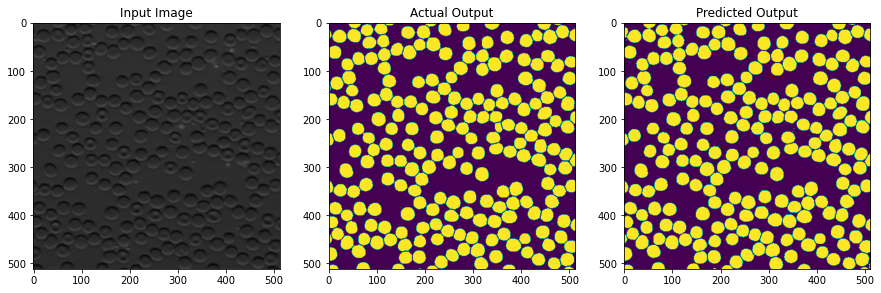

accuracy is
tensor(0.9791, device='cuda:0')
torch.Size([1, 1, 512, 512])


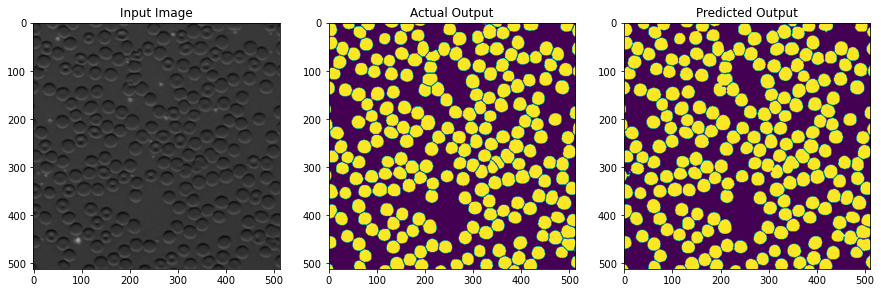

accuracy is
tensor(0.9811, device='cuda:0')
torch.Size([1, 1, 512, 512])


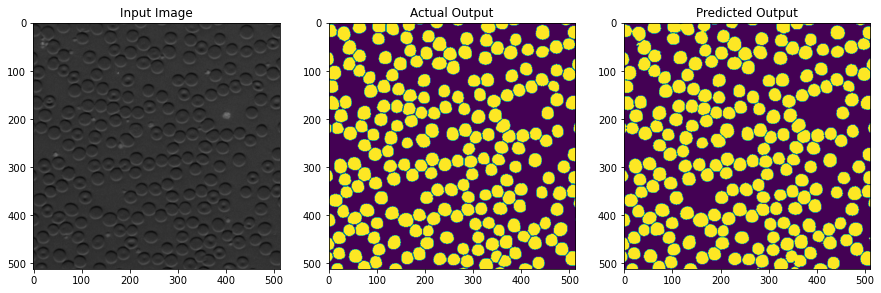

accuracy is
tensor(0.9802, device='cuda:0')
torch.Size([1, 1, 512, 512])


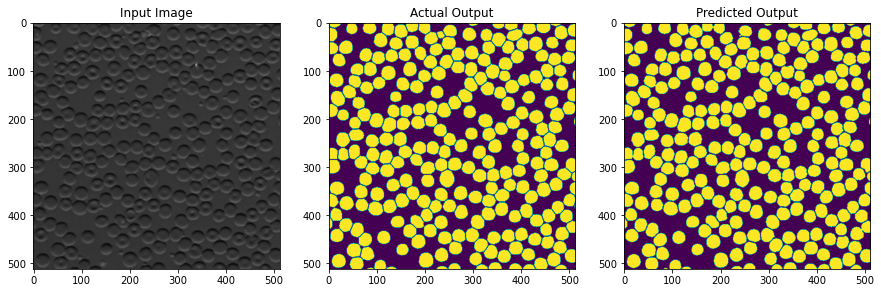

accuracy is
tensor(0.9773, device='cuda:0')
torch.Size([1, 1, 512, 512])


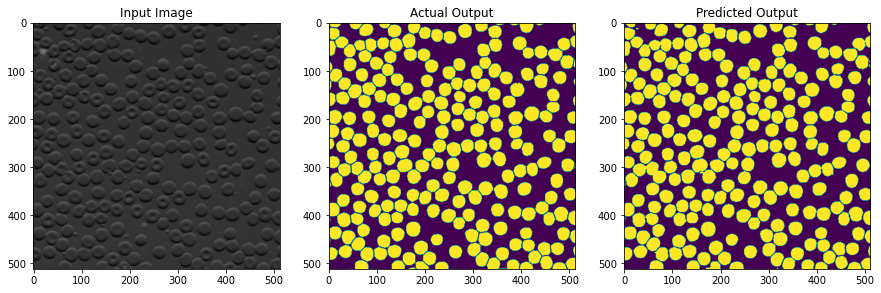

accuracy is
tensor(0.9790, device='cuda:0')
torch.Size([1, 1, 512, 512])


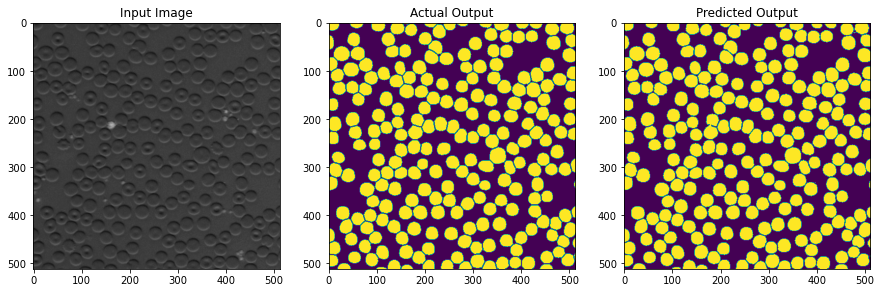

accuracy is
tensor(0.9808, device='cuda:0')
torch.Size([1, 1, 512, 512])


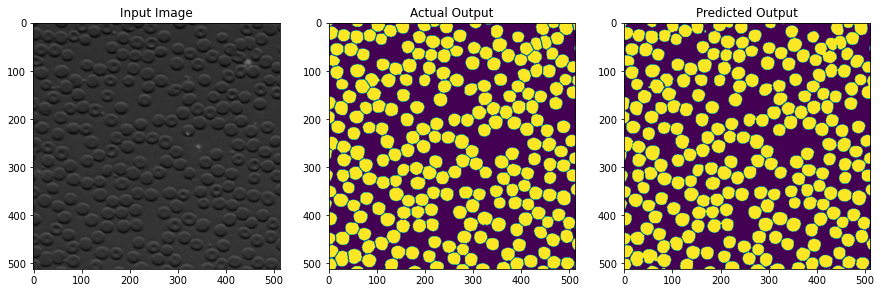

accuracy is
tensor(0.9745, device='cuda:0')


In [9]:
## Plot some images

from skimage.measure import label as labeler


def accuracy(output, target):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        
        threshold = threshold_otsu(output.cpu().detach().numpy())
        output = (output > threshold) * 1
        res = [];
        j = jaccard_sim(output, target)
    
        
        
        return j

def jaccard_sim(img1, img2):
    n = img1.shape[-1]**2
    a = img1 * img2
    b = img1 + img2 - a
    J = a/b
    J[torch.isnan(J)] = 1
    j = torch.sum(J)/n

    return j

def show(img,output,label,denorm = False):
    img,output,label = img.cpu(),output.cpu(),label.cpu()
    fig,ax = plt.subplots(len(output),3,figsize=(15,30))
    cols = ['Input Image','Actual Output','Predicted Output']
    for i in range(len(output)):
        if(len(output) == 3):
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[i][0].imshow(Img.permute(1,2,0))
            ax[i][2].imshow(Lab)
            ax[i][1].imshow(act.permute(1,2,0))
        else:
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[0].imshow(Img.permute(1,2,0))
            ax[2].imshow(Lab)
            ax[1].imshow(act.permute(1,2,0))
            #ax[0].title('this')
            for ax, col in zip(ax, cols):
                ax.set_title(col)
    plt.show()
    
def mask_pred(ouput, label, device):
    
    
    threshold = threshold_otsu(output.cpu().detach().numpy())
    mask = (output >= threshold) * 1
    
    print(mask.shape)
 
    # mask = mask.cpu().detach().numpy()
    
    # Convert output to np
    output_np = output.cpu().detach().numpy()
    
#     predict_labels = labeler(mask)
    
#     # convert back to torch 
#     predict_labels = torch.from_numpy(predict_labels).to(device)

    return mask
    
c = 0
device = 'cuda'
for img,label in (test_dataloader):
        # img = img.float().to(device)
        # img = img / 256
        # print(label)
        label = label.float().to(device)
        img = img.to(device)
        # output = model(img)
        
        # ouput = model_int8(img)
        
        output = model(img)
        
        pred_output = mask_pred(output, label, device)

        show(img,pred_output,label)
        print('accuracy is')
        print(accuracy(output,label))
        if c>5:
            break
        c+=1
        

    
    
#         results = model.predict(inputs)
#         output = np.clip(results[0] * 255, 0, 255)[:, :, 0].astype('uint8')
#         imageio.imwrite(f"octopi-pred-prob_{i}.png", output)
#         threshold = threshold_otsu(output)
#         mask = ((output > threshold) * 255).astype('uint8')
#         predict_labels = label(mask)
#         imageio.imwrite(f"octopi-pred-labels_{i}.png", predict_labels)

In [13]:
# Convert to Half - Precision and measure Jaccard 
model_cuda = model.to("cuda").eval()

model_cuda_half = model_cuda.half()


torch.Size([1, 1, 512, 512])


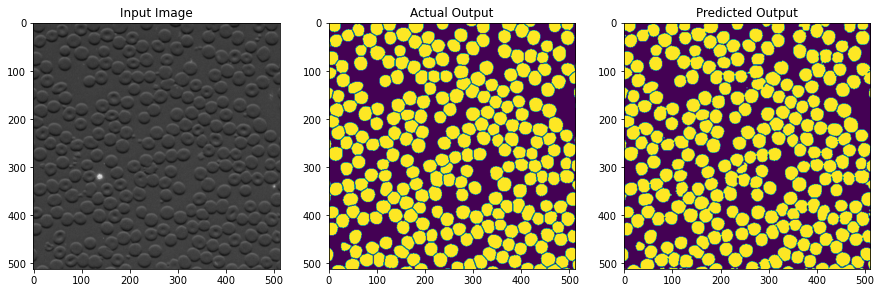

accuracy is
tensor(0.9723, device='cuda:0')
torch.Size([1, 1, 512, 512])


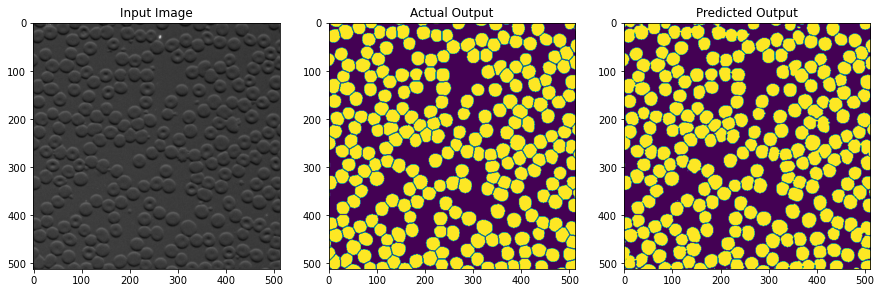

accuracy is
tensor(0.9730, device='cuda:0')
torch.Size([1, 1, 512, 512])


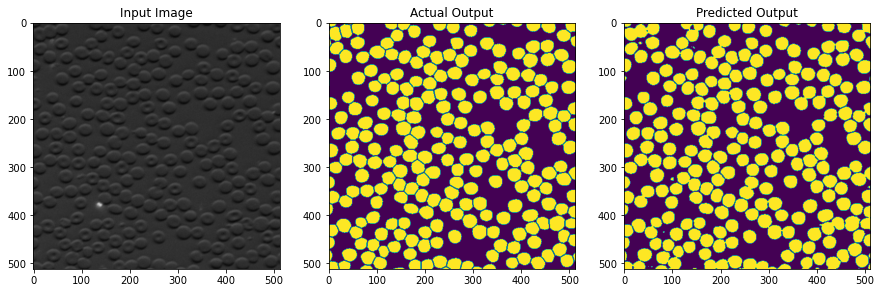

accuracy is
tensor(0.9673, device='cuda:0')
torch.Size([1, 1, 512, 512])


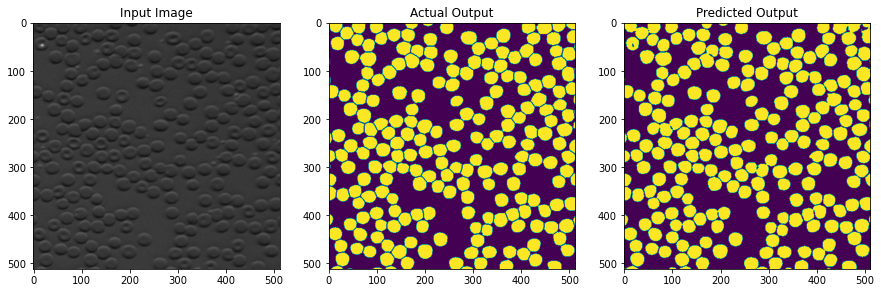

accuracy is
tensor(0.9732, device='cuda:0')
torch.Size([1, 1, 512, 512])


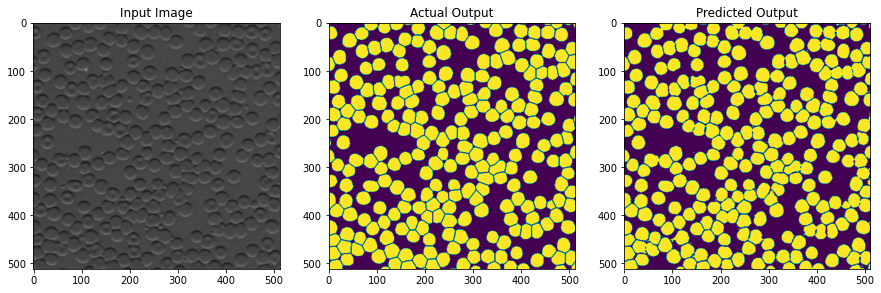

accuracy is
tensor(0.9696, device='cuda:0')
torch.Size([1, 1, 512, 512])


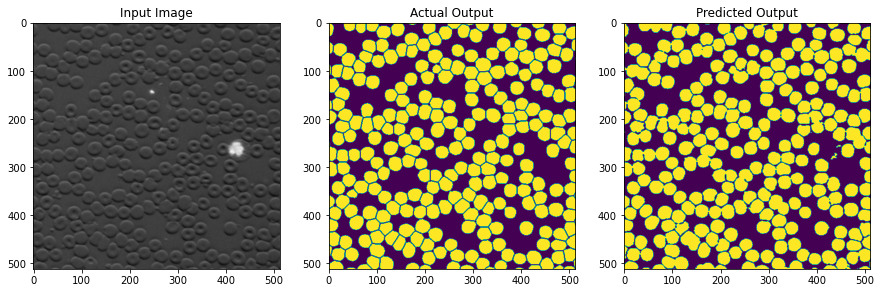

accuracy is
tensor(0.9600, device='cuda:0')
torch.Size([1, 1, 512, 512])


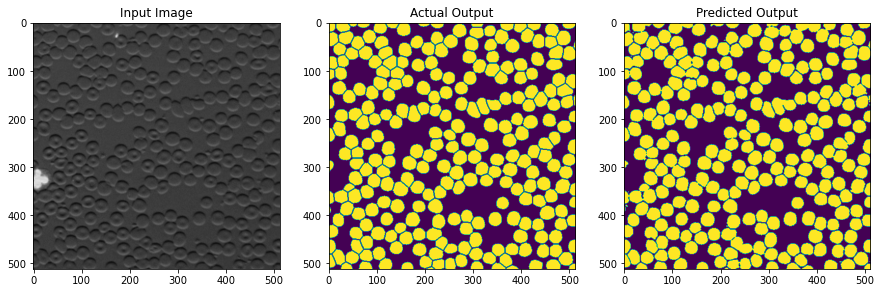

accuracy is
tensor(0.9733, device='cuda:0')


In [16]:


c = 0
device = 'cuda'
for img,label in (test_dataloader):
        # img = img.float().to(device)
        # img = img / 256
        # print(label)
        label = label.float().to(device)
        img = img.to(device)
        # img = img.half()
        # output = model(img)
        
        # ouput = model_int8(img)
        
        output = model_cuda_half(img.half())
        output = output.float()
        
        pred_output = mask_pred(output, label, device)

        show(img,pred_output,label)
        print('accuracy is')
        acc = 
        print(accuracy(output,label))
        sum += accuracy
        if c>5:
            break
        c+=1
        


In [17]:
# Quantization

model_fp32 = model.cpu()

model_fp32.eval()
model_fp32.qconfig = torch.quantization.get_default_qconfig('qnnpack')

model_fp32_prepared = torch.quantization.prepare(model_fp32)

# Calibrate with real world data
i = 0
for img,label in (test_dataloader):
    
    img = img.cpu()
    
    model_fp32_prepared(img)
    
    if i ==0:
        break
        
model_int8 = torch.quantization.convert(model_fp32_prepared)

input_fp32 = torch.randn(1, 3, 512, 512)


res = model_int8(input_fp32)

print(res)



/opt/conda/lib/python3.7/site-packages/torch/ao/quantization/observer.py:1137: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  Returning default scale and zero point "


tensor([[[[-1.8749,  2.8124,  1.4522,  ...,  0.8456,  2.8124,  0.5698],
          [-0.6985,  0.0184, -1.8749,  ..., -1.0478,  1.3786, -1.0478],
          [ 0.8456, -0.2206, -1.6360,  ...,  2.0220,  2.3161, -1.0478],
          ...,
          [-0.3676,  1.5441,  1.2867,  ...,  1.1764,  0.5698,  0.8456],
          [ 0.4595, -0.9559,  0.4595,  ..., -0.2206,  2.8124,  0.8456],
          [ 1.5441,  2.2426,  0.4595,  ...,  2.8124,  2.8124,  0.8456]]]])


In [ ]:
input_fp32 = torch.randn(1, 3, 512, 512)
res = model_int8(input_fp32)
print(res)

inp2 = input_fp32
res2 = model(inp2)
print(res2)


In [19]:
## Inference speed
import time
trials = 100
total_time = 0

device = 'cpu'
inp = torch.randn([1, 3, 512, 512]).to(device)
output = model_int8(inp)
    
for i in range(trials):
    device = 'cpu'
    inp = torch.randn([1, 3, 512, 512]).to(device)
    torch.cuda.synchronize()
    start_epoch = time.time()
    output = model_int8(inp)
    torch.cuda.synchronize()
    end_epoch = time.time()
    elapsed = end_epoch - start_epoch
    total_time += elapsed

print('The average time per inference for quantized m2unet is')
print(total_time/trials)


## Inference speed
trials = 100
total_time = 0

# Warm up 
device = 'cpu'
inp = torch.randn([1, 3, 512, 512]).to(device)
torch.cuda.synchronize()
model_cpu = model.cpu()
output = model_cpu(inp)

for i in range(trials):
    device = 'cpu'
    inp = torch.randn([1, 3, 512, 512]).to(device)
    torch.cuda.synchronize()
    start_epoch = time.time()
    output = model_cpu(inp)
    torch.cuda.synchronize()
    end_epoch = time.time()
    elapsed = end_epoch - start_epoch
    total_time += elapsed

print('The average time per inference for unquantized m2unet is')
print(total_time/trials)


The average time per inference for quantized m2unet is
0.1800088667869568
The average time per inference for unquantized m2unet is
0.05776344776153564


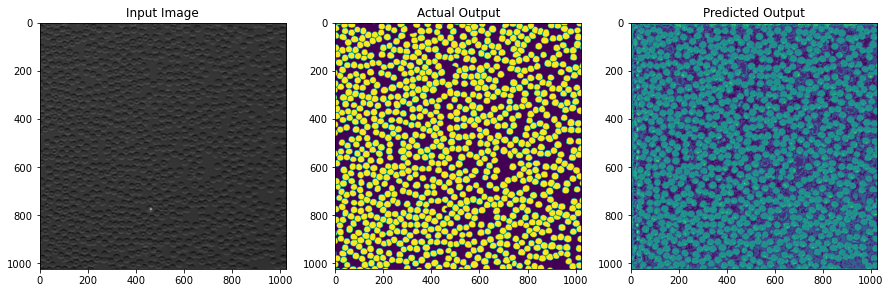

accuracy is
tensor(0.8745, device='cuda:0')
unquantized model


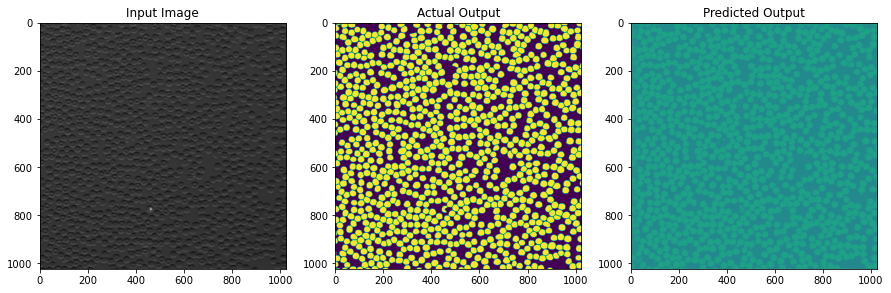

accuracy is
tensor(0.9236, device='cuda:0')


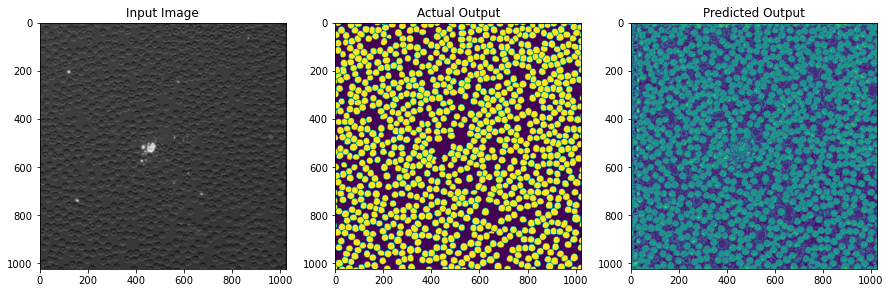

accuracy is
tensor(0.8573, device='cuda:0')
unquantized model


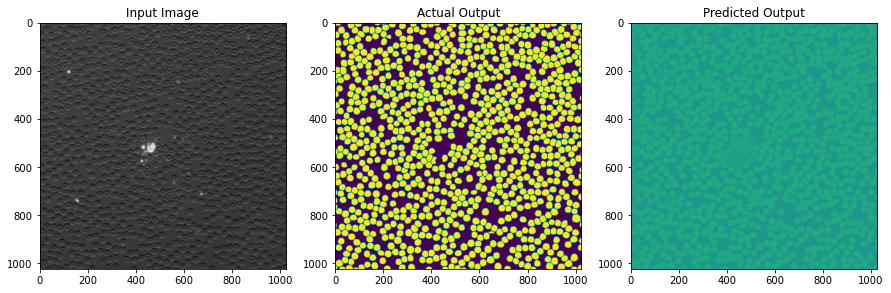

accuracy is
tensor(0.9278, device='cuda:0')


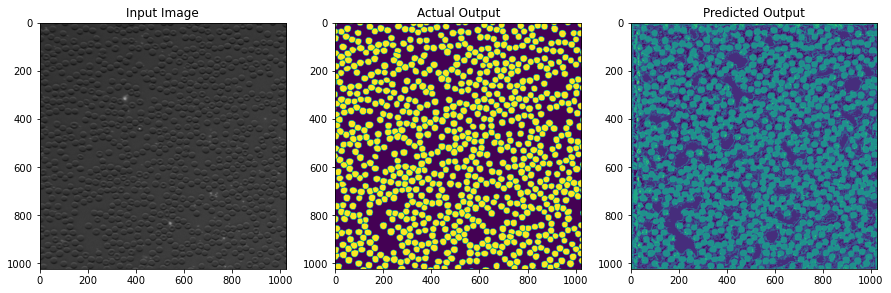

accuracy is
tensor(0.7539, device='cuda:0')
unquantized model


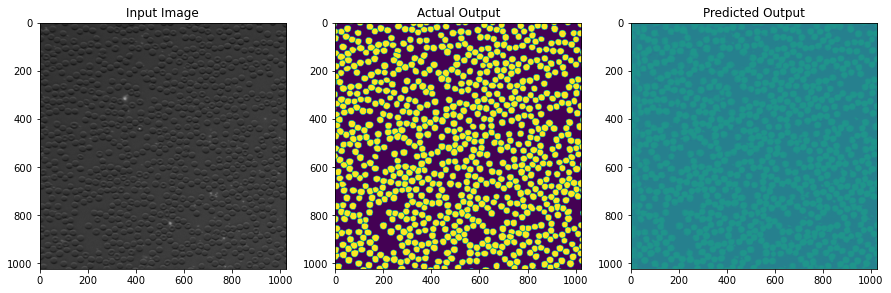

accuracy is
tensor(0.9255, device='cuda:0')


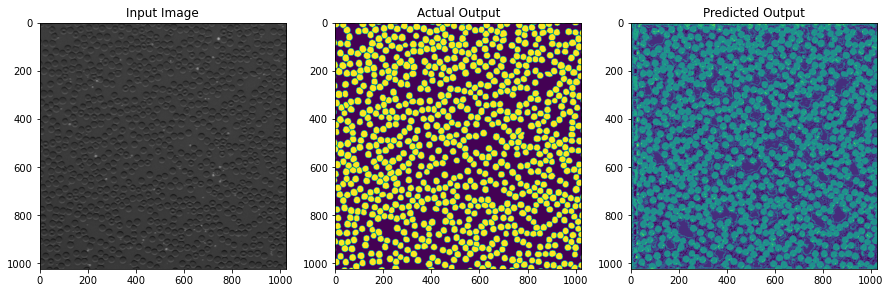

accuracy is
tensor(0.7641, device='cuda:0')
unquantized model


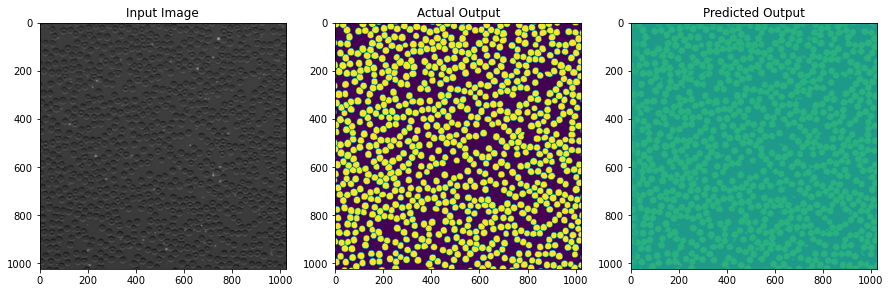

accuracy is
tensor(0.9431, device='cuda:0')


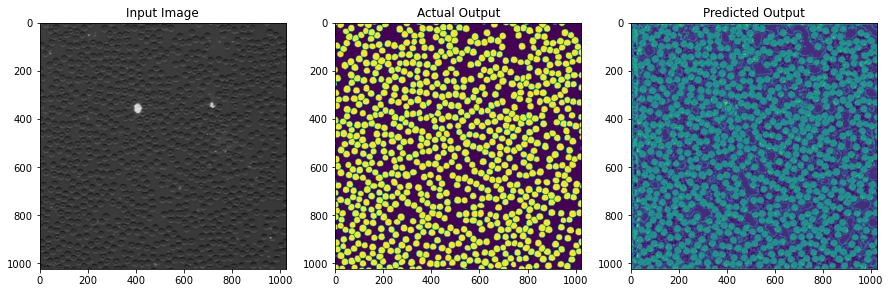

accuracy is
tensor(0.7658, device='cuda:0')
unquantized model


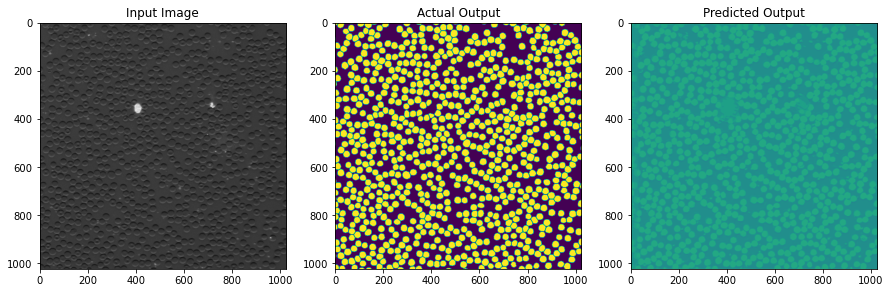

accuracy is
tensor(0.9430, device='cuda:0')


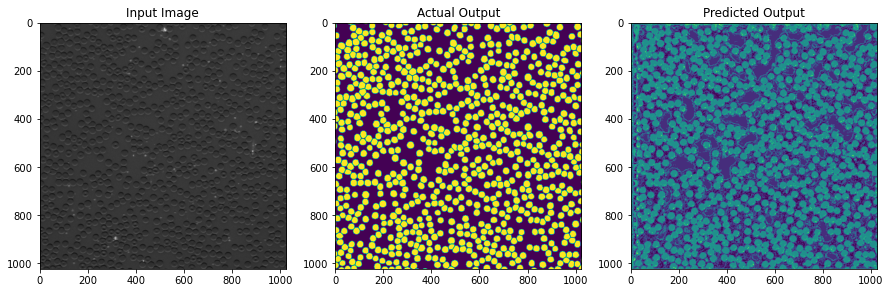

accuracy is
tensor(0.7673, device='cuda:0')
unquantized model


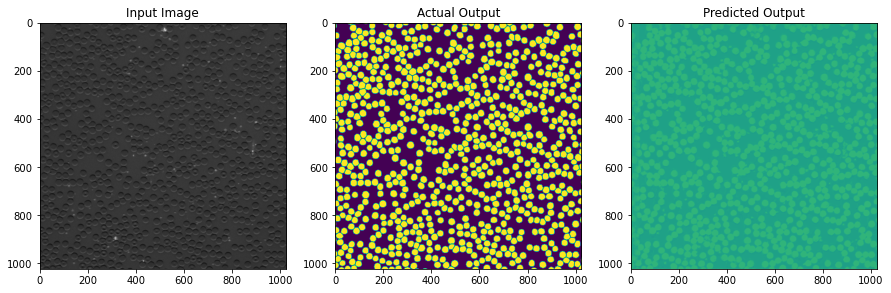

accuracy is
tensor(0.9427, device='cuda:0')


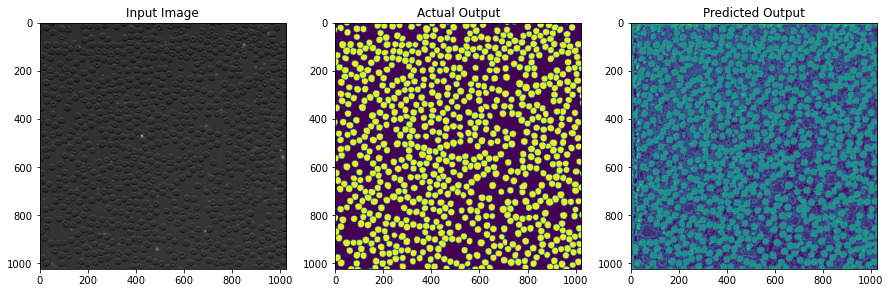

accuracy is
tensor(0.8478, device='cuda:0')
unquantized model


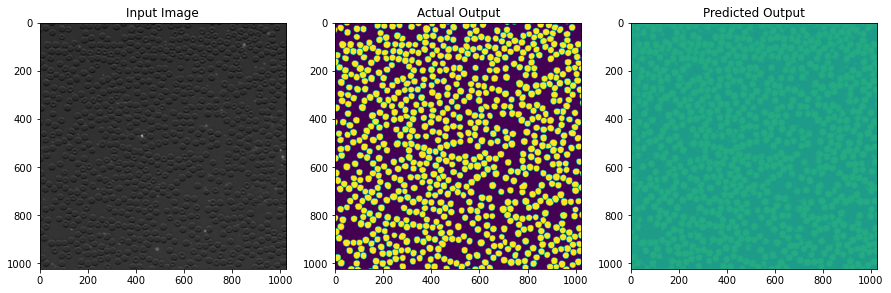

accuracy is
tensor(0.9100, device='cuda:0')


In [29]:
'''
Plot comparison of quantized to unquantized
'''
def mask_pred(ouput, label, device):
    
    
    threshold = threshold_otsu(output.cpu().detach().numpy())
    mask = (output >= threshold) * 1
 

    print(mask)
    # mask = mask.cpu().detach().numpy()
    
    # Convert output to np
    output_np = output.cpu().detach().numpy()
    
#     predict_labels = labeler(mask)
    
#     # convert back to torch 
#     predict_labels = torch.from_numpy(predict_labels).to(device)

    return mask


def show(img,output,label,denorm = False):
    img,output,label = img.cpu(),output.cpu(),label.cpu()
    fig,ax = plt.subplots(len(output),3,figsize=(15,30))
    cols = ['Input Image','Actual Output','Predicted Output']
    for i in range(len(output)):
        if(len(output) == 3):
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[i][0].imshow(Img.permute(1,2,0))
            ax[i][2].imshow(Lab)
            ax[i][1].imshow(act.permute(1,2,0))
        else:
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[0].imshow(Img.permute(1,2,0))
            ax[2].imshow(Lab)
            ax[1].imshow(act.permute(1,2,0))
            #ax[0].title('this')
            for ax, col in zip(ax, cols):
                ax.set_title(col)
    plt.show()
    
c = 0

# device = 'cpu'
for img,label in (test_dataloader):
        # img = img.float().to(device)
        # img = img / 256
        # print(label)
        device = 'cpu'
        label = label.float().to(device)
        img = img.to(device)
        
        # output = model(img)
        
        # ouput = model_int8(img)
        
        output = model_int8(img)

        device = 'cuda:0'
        label = label.float().to(device)
        img = img.to(device)
        output = output.to(device)
        
        show(img,output,label)
        
        print('accuracy is')
        print(accuracy(output,label))
        
        # Unquantized Model
        img = img.to('cpu')

        print('unquantized model')
        output = model(img)
        output = output.to(device)

        show(img,output,label)

        
        
        
        print('accuracy is')
        print(accuracy(output,label))
        if c>5:
            break
        c+=1
        
 

In [28]:
test = torch.randn([1, 1, 12, 12])

threshold  = .2

mask = (test >= threshold) * 1

print(mask)





tensor([[[[0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
          [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
          [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0],
          [1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0],
          [0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1],
          [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1],
          [0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
          [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
          [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0],
          [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0]]]])
